# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

from jcopml.plot import plot_missing_value
from jcopml.plot import plot_confusion_matrix
from jcopml.plot import plot_roc_curve
from jcopml.plot import plot_classification_report
from jcopml.plot import plot_pr_curve

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_indo = stopwords.words('indonesian') 

import seaborn as sns

# 2. Import Dataset

In [2]:
df = pd.read_csv('spam.csv')
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1


# 3. Exploratory Data Analysis (EDA)

### Data Information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [4]:
df.shape

(1143, 2)

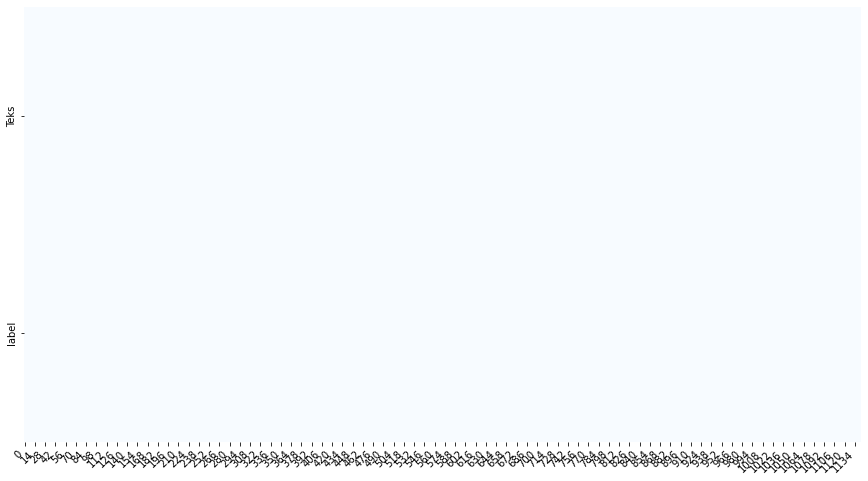

In [5]:
plot_missing_value(df)

### Data Description

In [6]:
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1


In [7]:
df.describe()

,label
count,1143.000000
mean,0.502187
std,0.500214
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
df.groupby('label').describe()

Teks                                                               
      count unique                                                top freq
label                                                                     
0       569    568  bebas nama1, terus nanti kalau ada tgl libur, ...    2
1       574    574  [PROMO] Beli paket Flash mulai 1GB di MY TELKO...    1

```json
The dataset explains 569 texts is not spam and 574 texts is spam.
```

### Count a Character in Text Message

In [9]:
df['Character'] = df['Teks'].apply(len)
df.head()

,Teks,label,Character
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1,153
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1,152
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1,152
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1,153
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1,113


<AxesSubplot:ylabel='Frequency'>

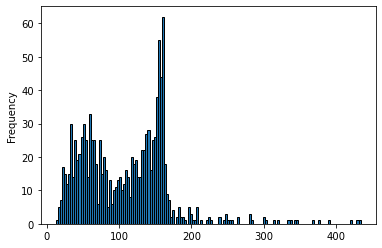

In [10]:
# Visualize a length of Character in text message

df['Character'].plot.hist(bins = 150, edgecolor='black')

In [11]:
df.Character.describe()

count    1143.000000
mean      108.736658
std        59.076768
min        13.000000
25%        58.000000
50%       113.000000
75%       152.000000
max       434.000000
Name: Character, dtype: float64

In [12]:
#Grab the maximum character in text message

df[df['Character'] == 434]['Teks'].iloc[0]

"pesan dari nama1 : Assalamu'alaikum wr.wb. Pak, Indonesia Android Kejar bekerjasama dengan Depilkom mau mengadakan pelatihan Android level intermediate, masih ada slot 2 orang lagi, syaratnya sudah pernah membuat app android dan ngebuild menggunakan Android Studio, barang kali di kelas Bapak ada yang berminat. Nuhun.o ya pelatihannya mulai hari sabtu besok, 2 April, setiap sabtu selama 7 pertemuan, bertempat di lab praktikum kita."

### Visualize Label Distribution

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

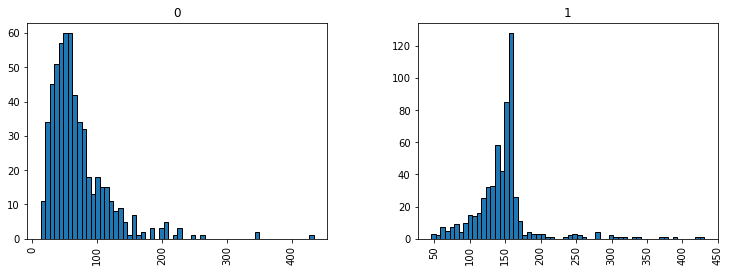

In [13]:
df.hist(column='Character', by='label', bins =60, figsize=(12,4), edgecolor='black')

## Cleaning Dataset

In [14]:
df

,Teks,label,Character
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1,153
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1,152
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1,152
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1,153
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1,113
...,...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,46
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,52
1140,Mba mau kirim 300 ya,0,20
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,51


In [15]:
import re

In [16]:
def clean_data(text):
    text = text.lower()
    clean_word = word_tokenize(text)
    clean_word = [word for word in clean_word if word not in punctuation]
    clean_word = [word for word in clean_word if word not in sw_indo]
    emoji_removal = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    clean_word = ' '.join(clean_word)
    return emoji_removal.sub(r'', clean_word)

In [17]:
df.Teks = df.Teks.apply(clean_data)
df.Teks

0       promo beli paket flash 1gb my telkomsel app dp...
1       2.5 gb/30 rp 35 ribu spesial terpilih aktifkan...
2       2016-07-08 11:47:11.plg yth sisa kuota flash 4...
3       2016-08-07 11:29:47.plg yth sisa kuota flash 7...
4       4.5gb/30 rp 55 ribu spesial terpilih aktifkan ...
                              ...                        
1138                     yooo sama2 oke umumin grup kelas
1139               ga ad nulis kerudung kirain warna jins
1140                                     mba kirim 300 ya
1141      nama1 beaok bwrangkat pagi ... cas atay tranfer
1142                                          no bri nama
Name: Teks, Length: 1143, dtype: object

## Check Imbalanced Dataset

C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

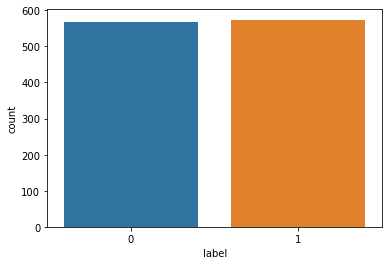

In [18]:
sns.countplot(df.label)

In [19]:
df.label.value_counts()

1    574
0    569
Name: label, dtype: int64

```json
The dataset is balanced.
```

# 4. Dataset Splitting

In [20]:
X = df.Teks
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((914,), (229,), (914,), (229,))

# 5. Modeling

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer()),
    ('algo', SVC(max_iter=500, probability=True))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter= 50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   17.8s finished


{'algo__C': 93.84800715909546, 'algo__gamma': 0.13820379228637006}
1.0 0.9682700603968938 0.982532751091703


C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\sklearn\svm\_base.py:228: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


# 6. Hyperparameters Tuning

In [23]:
from jcopml.tuning.space import Integer, Real

In [24]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer()),
    ('algo', SVC(max_iter=500, probability=True))
])

parameter = {'algo__gamma': Real(low=-2, high=3, prior='log-uniform'),
             'algo__C': Real(low=-1, high=3, prior='log-uniform')}


model = RandomizedSearchCV(pipeline, parameter, cv=3, scoring='accuracy', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   17.8s finished
C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\sklearn\svm\_base.py:228: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 213.68329072358785, 'algo__gamma': 0.11526449540315616}
1.0 0.9682700603968938 0.982532751091703


# 7. Evaluation

## 7.1. Classification Report

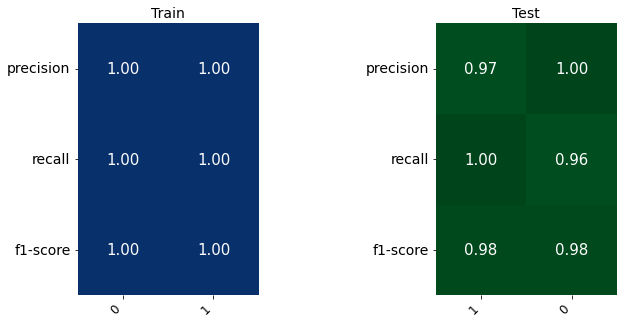

In [25]:
plot_classification_report(X_train, y_train, X_test, y_test, model)

In [26]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       455
           1       1.00      1.00      1.00       459

    accuracy                           1.00       914
   macro avg       1.00      1.00      1.00       914
weighted avg       1.00      1.00      1.00       914


Test report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       114
           1       0.97      1.00      0.98       115

    accuracy                           0.98       229
   macro avg       0.98      0.98      0.98       229
weighted avg       0.98      0.98      0.98       229



## 7.2. Confusion Matrix

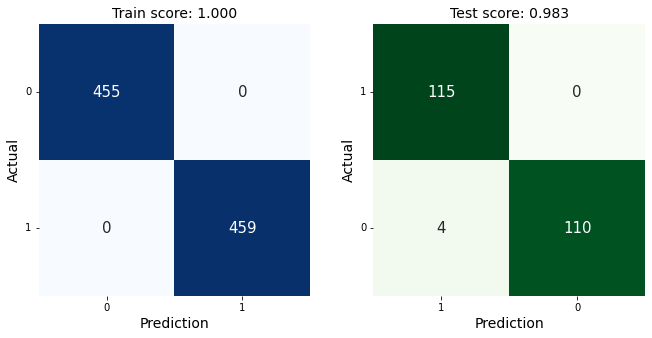

In [27]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

## 7.3. ROC AUC Curve

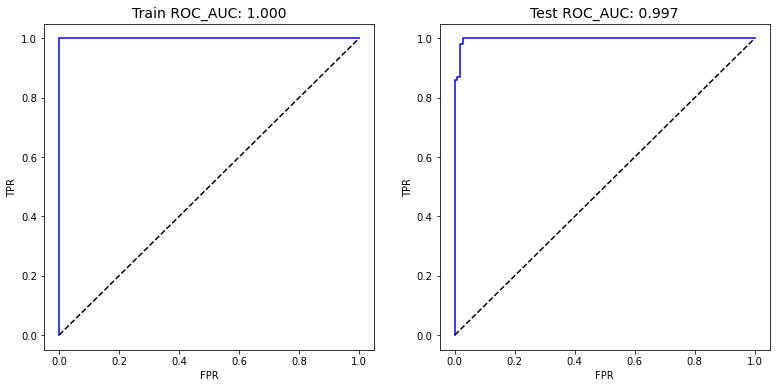

In [28]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

## 7.4. Precision-Recall Curve

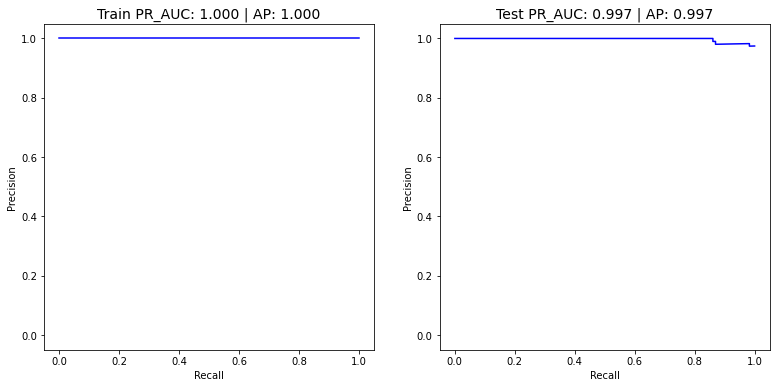

In [29]:
plot_pr_curve(X_train, y_train, X_test, y_test, model)

# 8. Sanity Check

In [30]:
text = ['Saynk tlong blikan mama pulsa ke nomr ini: 085283264267632, nnti mama tf blik. in nana pke hp kang sayur']
model.predict(text), model.predict_proba(text)

(array([1], dtype=int64), array([[0.10586539, 0.89413461]]))

In [31]:
text = ['Permisi, Bpk/Ibu Siapa Tahu Butuh Dana INGIN KEMBANGKAN USAHA & Kebutuhan Lain Min 5jt S/D 500 jt Bunga 2% Silakan Whatsapp 08524301662364']
model.predict(text), model.predict_proba(text)

(array([1], dtype=int64), array([[0.2258423, 0.7741577]]))

In [32]:
text = ['Di depan indomaret ya, Pak. Terima kasih.']
model.predict(text), model.predict_proba(text)

(array([0], dtype=int64), array([[0.82395973, 0.17604027]]))

### Result Analysis

In [33]:
df_analysis = pd.DataFrame(X_test, columns=['Teks'])
df_analysis['Prediction'] = model.predict(X_test)
df_analysis['Actual'] = y_test
df_analysis

,Teks,Prediction,Actual
311,info resmi tri care selamat nomor terpilih had...,1,1
704,ceritanya aja tp tetep bikin nangis,0,0
8,aktifkan iring coboy jr terhebat tekan 808 7 i...,1,1
638,assalamualaikum akang teteh lupa ya carrier da...,0,0
1009,sidang depaaan mel jahaaat pisaaan,0,0
...,...,...,...
708,da gapapa public dimasukin,0,0
911,masak dikosan makan orek buatan min,0,0
169,paket tsel flash tgl 07/08/2016 diperpanjang d...,1,1
843,ka ga liat kosannya skrg ngerjain uts take hom...,0,0


In [34]:
df_analysis[(df_analysis['Prediction'] == 0) & (df_analysis['Actual'] == 1)] 

,Teks,Prediction,Actual


In [35]:
df_analysis[(df_analysis['Prediction'] == 1) & (df_analysis['Actual'] == 0)] 

,Teks,Prediction,Actual
734,angka 0,1,0
1078,terima kasih konfirmasinya orderan proses,1,0
900,maaf keyword masukkan 234 salah info hub call ...,1,0
992,pemakaian internet sdh mencapai batasfup kecep...,1,0


# Save Model

In [36]:
save_model(model.best_estimator_, 'SMS_Spam_Classifier_Support_Vector_Classifier.pkl')

Model is pickled as model/SMS_Spam_Classifier_Support_Vector_Classifier.pkl
